Time: 0.03342437744140625 s for 2 molecules with 100 atoms


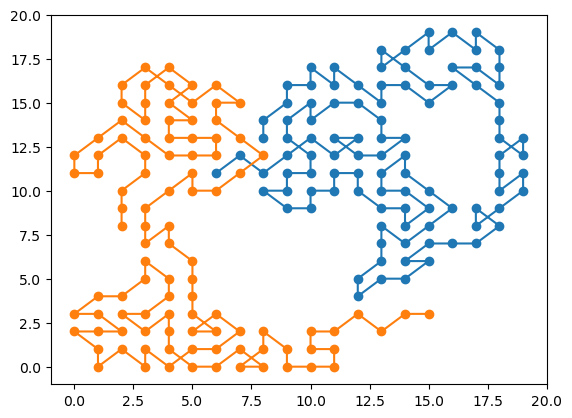

In [47]:
import numpy as np
import random
import matplotlib.pyplot as plt
import time

start_time = time.time() # Starting a timer

class System: # The array within which the molecules will sit
    
    def __init__(self, mol_len, num_mols, atom_sequence = 0, density = 1): # Default density is 1 gram per cm^3
        self.mol_len = mol_len
        self.num_mols = num_mols
        self.atom_sequence = atom_sequence
        self.density = density
        self.all_paths = []
        self.sys_hist = []
        self.array = np.array([0])
        self.box_length = 0

    def save(self, array, sys_state):
        """Saves the system such that it can be rolled back."""
        self.sys_state = np.copy(array)
        self.sys_hist.append(sys_state)
        
        return sys_state

    def undo(self):
        """Returns system state back to before the random moves were made."""
        self.array = sys_state
        return array

    def mega_undo(self):
        """Reverts system state back to a previous version."""
        self.sys_state = self.sys_hist[-1]
        self.array = self.sys_state
        self.sys_hist = self.sys_hist[:-1]

    # Plotting the path
    def plot(self):
        """Graphs the paths of the creation of the molecules."""
        print("Time:", time.time() - start_time, "s for", len(self.all_paths), "molecules with", self.mol_len, "atoms")
        for path in self.all_paths:
            path = np.array(path)
            plt.plot(path[:, 1], path[:, 0], marker='o')
        plt.xlim([-1, self.box_length])
        plt.ylim([-1, self.box_length])
        plt.show()

    def output(self):
        pass

    # Defining check to see if there is already a 'molecule' at that position
    def check(self, move, position):
        """Checks to see if a move is possible."""
        temp = position + move
        temp_tuple = tuple(temp) # Allowing comparison to array position
        if (temp[0] >= self.box_length or temp[1] >= self.box_length or temp[0] < 0 or temp[1] < 0 or 
        temp_tuple in {tuple(pos) for path in self.all_paths for pos in path}): # Check if move is occupied by previous molecule
            return False, position
        elif self.array[temp[0], temp[1]] == 0: # Check if move is possible
            position = temp
            self.array[position[0], position[1]] = 1
            return True, position
        else:
            return False, position

    def walk(self):
        """Creates a path taken by a Monte-Carlo simulation to make a chain of atoms."""
        self.box_length = 2 * int(np.ceil(np.sqrt(self.mol_len / self.density))) # Calculates requisite box size
        self.array = np.zeros((self.box_length, self.box_length)) # The 'box'
        moves = np.array([[1,0],[-1,0],[0,1],[0,-1],[1,1],[-1,1],[1,-1],[-1,-1]]) # Possible moves for the random walk
        for path in range(self.num_mols):
            path = []
            position = np.array([random.randint(0, self.box_length - 1), random.randint(0, self.box_length - 1)])
            self.array[position[0], position[1]] = 1
            path.append(position.tolist())
            i = 0 # Count of atoms placed
            j = 0 # Count of rejected moves
            while i < (self.mol_len - 1): # Iterate through every atom in the molecule
                move = moves[random.randint(0, 7)]
                if j >= self.mol_len * 2: # Check if too many erroneous moves have been made
                    # Resetting the array and position
                    self.array.fill(0)
                    position = np.array([random.randint(0, self.box_length - 1), random.randint(0, self.box_length - 1)])
                    self.array[position[0], position[1]] = 1
                    path = [position.tolist()]
                    i = 0
                    j = 0
                    # self.undo()
                    # i = 0
                    # j = 0
                    continue
                success, position = self.check(move, position)
                if not success:
                    j += 1
                    continue           
                path.append(position.tolist())
                i += 1
            self.all_paths.append(path)
    

PPS = System(100,2)
PPS.walk()
PPS.plot()